In [19]:
import os
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import pickle
import matplotlib.pyplot as plt

## Load Data and normalization

In [2]:
print("[INFO] loading dataset...")

path = os.path.join("dataset", "bounding")

dataset = pd.read_csv("{}/dataset.csv".format(path))

print("[INFO] Load image from path...")
image = []
img_x = []
img_y = []
img_w = []
img_h = []
labels = []

drop_index = []
for index, row in dataset.iterrows():
    img = cv2.imread(row["path"])
    (h, w) = img.shape[:2]
    
    x_result = float(row["x"]) / w
    y_result = float(row["y"]) / h
    w_result = float(row["w"]) / w
    h_result = float(row["h"]) / h
    
    
    img_x.append(1. if x_result > 1 else x_result)
    img_y.append(1. if y_result > 1 else y_result)
    img_w.append(1. if w_result > 1 else w_result)
    img_h.append(1. if h_result > 1 else h_result)
    labels.append(1 if row["label"] == "theft" else 0)
    
    img = load_img(row["path"], target_size=(320, 320))
    img = img_to_array(img)
    image.append(img)
        
print("[INFO] Success load image from path...")
        
boxes = np.array([img_x, img_y, img_w, img_h]).transpose()
images = np.array(image)/255.
labels = np.array(labels)

print("[INFO] Load labels to one hot encoding...")
encoding = OneHotEncoder()
labels = encoding.fit_transform(labels.reshape(-1, 1)).toarray()
print("[INFO] Success load labels to one hot encoding...")



print("[INFO] Success loading dataset")

[INFO] loading dataset...
[INFO] Load image from path...
[INFO] Success load image from path...
[INFO] Load labels to one hot encoding...
[INFO] Success load labels to one hot encoding
[INFO] Success loading dataset


In [3]:
labels.shape

(1041, 2)

## Split data training and data validation

In [4]:
split = train_test_split(images, boxes, labels, test_size=0.10, random_state=42)

(train_image, test_image) = split[:2]
(train_box, test_box) = split[2:4]
(train_label, test_label) = split[4:6]

## Model

In [5]:
mobile_net = MobileNetV2(
    weights = "imagenet", 
    include_top = False,
    input_tensor = Input(shape = (320, 320, 3), name = "image")
)

mobile_net.trainable = False
    
flatten = mobile_net.output
flatten = Flatten()(flatten)
    
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
                 name="bounding_box")(bboxHead)

softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(2, activation="softmax",
                    name="class_label")(softmaxHead)

model = Model(
    inputs = mobile_net.input,
    outputs = (bboxHead, softmaxHead)
)

model.summary()

2023-06-25 15:50:34.234729: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65536000 exceeds 10% of free system memory.
2023-06-25 15:50:34.292710: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65536000 exceeds 10% of free system memory.
2023-06-25 15:50:34.309195: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65536000 exceeds 10% of free system memory.
2023-06-25 15:50:34.480212: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 262144000 exceeds 10% of free system memory.
2023-06-25 15:50:35.205985: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 262144000 exceeds 10% of free system memory.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 160, 160, 32  864         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 160, 160, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 80, 80, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 81, 81, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 40, 40, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 40, 40, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 20, 20, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 20, 20, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 20, 20, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 20, 20, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 20, 20, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 20, 20, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 20, 20, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 20, 20, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 10, 10, 960)  8640       ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 10, 10, 960)  3840       ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 10, 10, 960)  0          ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 10, 10, 160)  153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

                                                                                                  
 bounding_box (Dense)           (None, 4)            132         ['dense_2[0][0]']                
                                                                                                  
 class_label (Dense)            (None, 2)            1026        ['dropout_1[0][0]']              
                                                                                                  
Total params: 84,452,774
Trainable params: 82,194,790
Non-trainable params: 2,257,984
__________________________________________________________________________________________________


In [ ]:
plot_model(
    model,
    show_shapes=True, 
    show_dtype=False, 
    show_layer_names=True, 
    expand_nested=True
)

## Training Model

In [7]:
losses = {
    "class_label": "binary_crossentropy",
    "bounding_box": "mean_squared_error",
}

loss_weights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

optimizer = Adam(learning_rate = 0.0001)
model.compile(loss = losses, optimizer = optimizer, metrics = ["accuracy"], loss_weights = loss_weights)

train_targets = {
    "class_label": train_label,
    "bounding_box": train_box
}

test_targets = {
    "class_label": test_label,
    "bounding_box": test_box
}

print("[INFO] training model...")
history = model.fit(
    train_image, train_targets,
    validation_data = (test_image, test_targets),
    batch_size = 32,
    epochs = 20,
    verbose = 1
)

[INFO] training model...
Epoch 1/20
30/30 [==============================] - 130s 4s/step - loss: 1.1113 - bounding_box_loss: 0.0610 - class_label_loss: 1.0503 - bounding_box_accuracy: 0.8397 - class_label_accuracy: 0.7479 - val_loss: 0.1001 - val_bounding_box_loss: 0.0590 - val_class_label_loss: 0.0410 - val_bounding_box_accuracy: 0.8381 - val_class_label_accuracy: 1.0000
Epoch 2/20
30/30 [==============================] - 102s 3s/step - loss: 0.3376 - bounding_box_loss: 0.0413 - class_label_loss: 0.2963 - bounding_box_accuracy: 0.8622 - class_label_accuracy: 0.9274 - val_loss: 0.0652 - val_bounding_box_loss: 0.0526 - val_class_label_loss: 0.0126 - val_bounding_box_accuracy: 0.8381 - val_class_label_accuracy: 0.9905
Epoch 3/20
30/30 [==============================] - 107s 3s/step - loss: 0.1570 - bounding_box_loss: 0.0330 - class_label_loss: 0.1240 - bounding_box_accuracy: 0.8654 - class_label_accuracy: 0.9690 - val_loss: 0.0531 - val_bounding_box_loss: 0.0465 - val_class_label_loss: 

## Saving model

In [18]:
is_dir_model_exist = os.path.exists("model")
if not is_dir_model_exist:
    os.makedirs("model")
    
model_path = os.path.join("model")

print("[INFO] saving object detector model...")
model.save("{}/detector.h5".format(model_path), save_format="h5")
print("[INFO] success saving object detector model")

print("[INFO] saving label one hot encoding...")
f = open("{}/one-hot.pickle".format(model_path), "wb")
f.write(pickle.dumps(encoding))
f.close()
print("[INFO] success saving label one hot encoding")

[INFO] saving object detector model...
[INFO] success saving object detector model
[INFO] saving label one hot encoding...
[INFO] success saving label one hot encoding


## Losses Graph

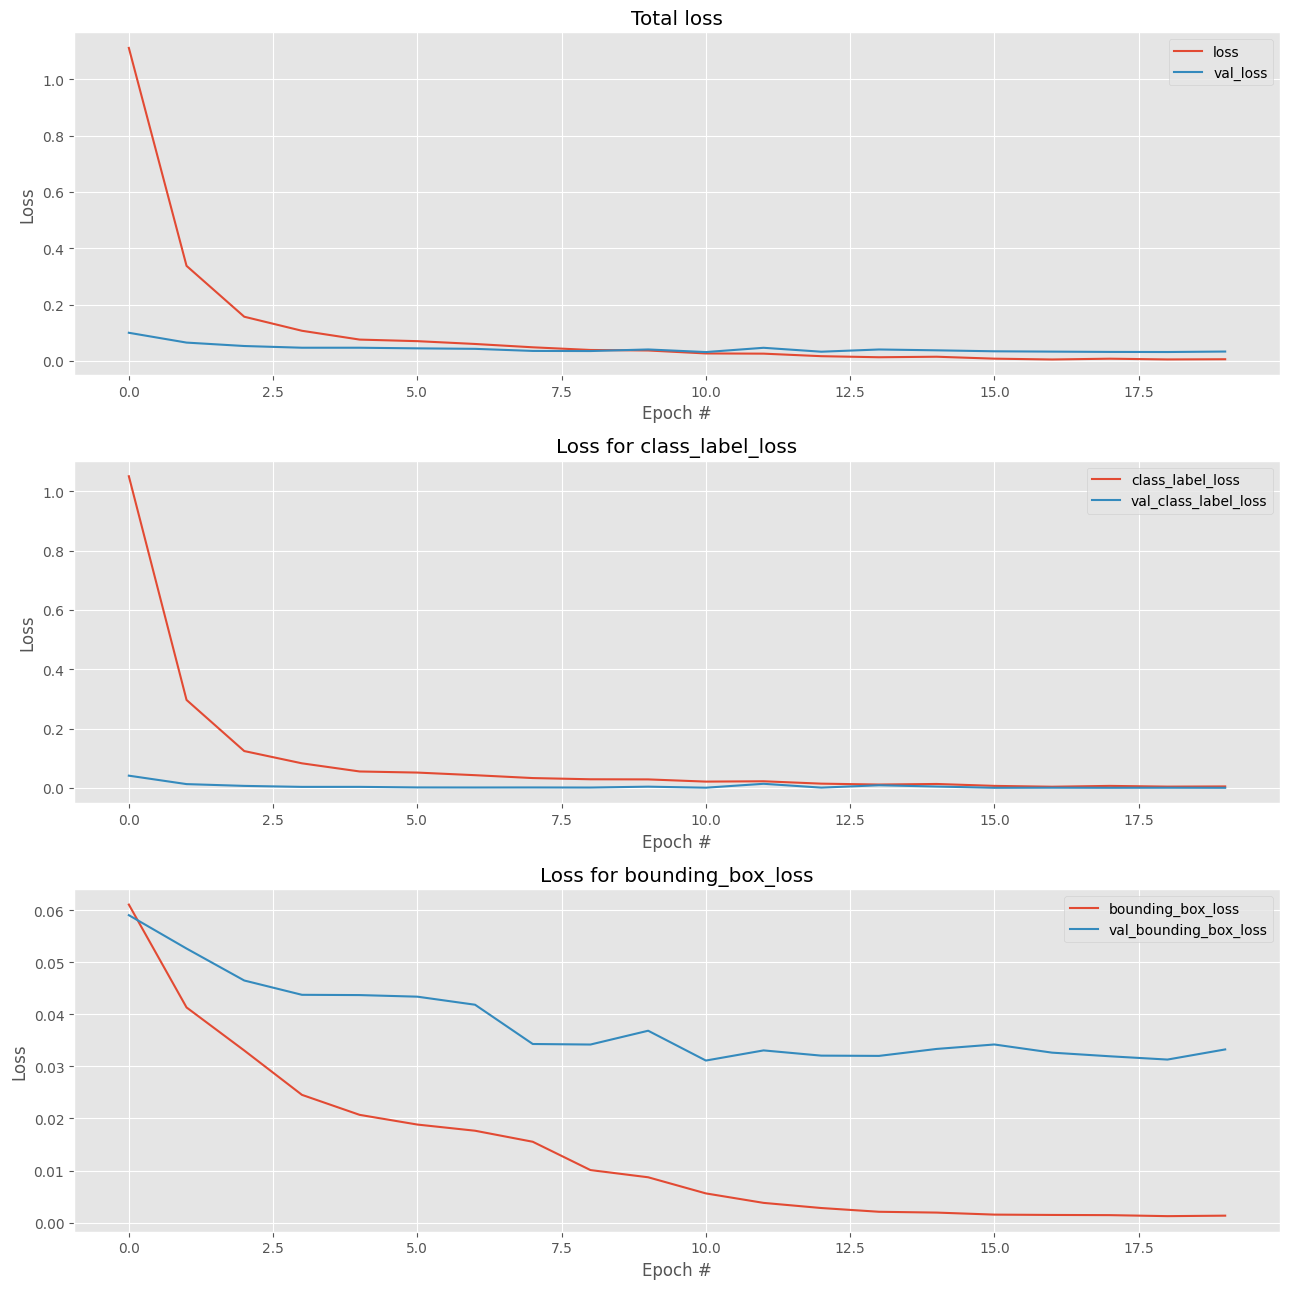

In [24]:
is_dir_result_exist = os.path.exists("result")
if not is_dir_result_exist:
    os.makedirs("result")

result_path = os.path.join("result")

lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
n_epoch = np.arange(0, 20)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
for (i, l) in enumerate(lossNames):
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(n_epoch, history.history[l], label=l)
    ax[i].plot(n_epoch, history.history["val_" + l], label="val_" + l)
    ax[i].legend()

plt.tight_layout()
plotPath = os.path.sep.join([result_path, "losses.png"])
plt.savefig(plotPath)
plt.show()
plt.close()

## Label Accuracy

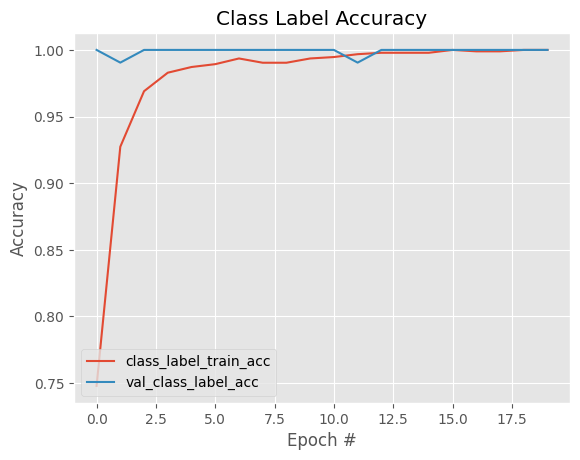

In [25]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(
    n_epoch, 
    history.history["class_label_accuracy"],
    label="class_label_train_acc"
)
plt.plot(
    n_epoch,
    history.history["val_class_label_accuracy"],
    label="val_class_label_acc"
)
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

plotPath = os.path.sep.join([result_path, "accs.png"])
plt.savefig(plotPath)
plt.show()
plt.close()